In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

# From [StackOverflow](http://stackoverflow.com/questions/24804298/fit-a-function-to-data-observations-pymcmc-pymc)

> I am trying to fit some data with a Gaussian (and more complex) function(s). I have created a small example below.

> My first question is, am I doing it right?

Yes!  You need to include a burn-in period, which you know.  I like to throw out the first half of my samples.  You don't need to do any thinning, but sometimes it will make your post-MCMC work faster to process and smaller to store.

The only other thing I advise is to set a random seed, so that your results are "reproducible": `np.random.seed(12345)` will do the trick.

Oh, and if I was really giving too much advice, I'd say `import seaborn` to make the `matplotlib` results a little more beautiful.

> My second question is, how do I add an error in the x-direction, i.e. in the x-position of the observations/data?

One way is to include a latent variable for each error.  This works in your example, but will not be feasible if you have many more observations.  I'll give a little example to get you started down this road.

> It is very hard to find nice guides on how to do this kind of regression in PyMC. Perhaps because its easier to use some least squares, or similar approach, I however have many parameters in the end and need to see how well we can constrain them and compare different models, pyMC seemed like the good choice for that.

Someone should write a book!

In [2]:
# set random seed for reproducibility
np.random.seed(12345)

x = np.arange(5,400,10)*1e3

# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

# Gaussian function
gauss = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gauss(x=x,amp=amp_true, size=size_true, ps=ps_true )

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
f = f_true + noise 
f_error = np.ones_like(f_true)*0.05*f.max()

In [3]:
# define the model/function to be fitted.
def model(x, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)

    @pm.deterministic(plot=False)
    def gauss(x=x, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pm.MCMC(model(x,f))
MDL.sample(20000, 10000, 1)

 [-----------------100%-----------------] 20000 of 20000 complete in 3.9 sec

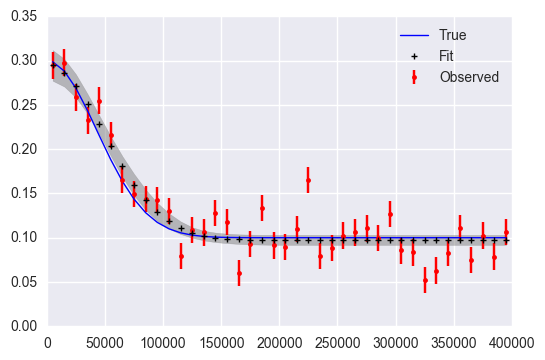

In [4]:
# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

Plotting ps
Plotting amp
Plotting size


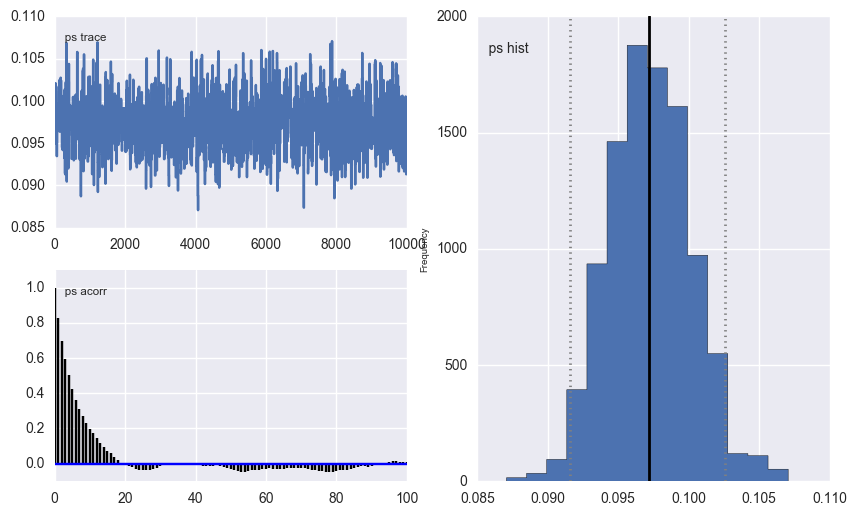

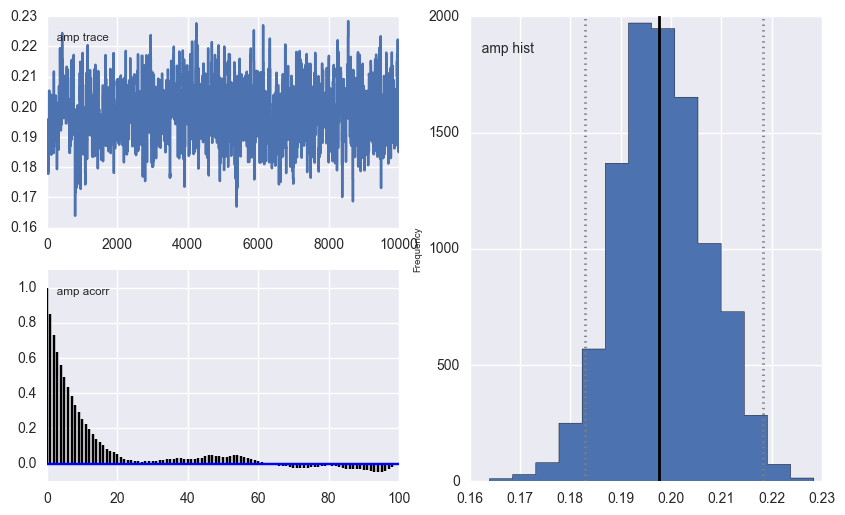

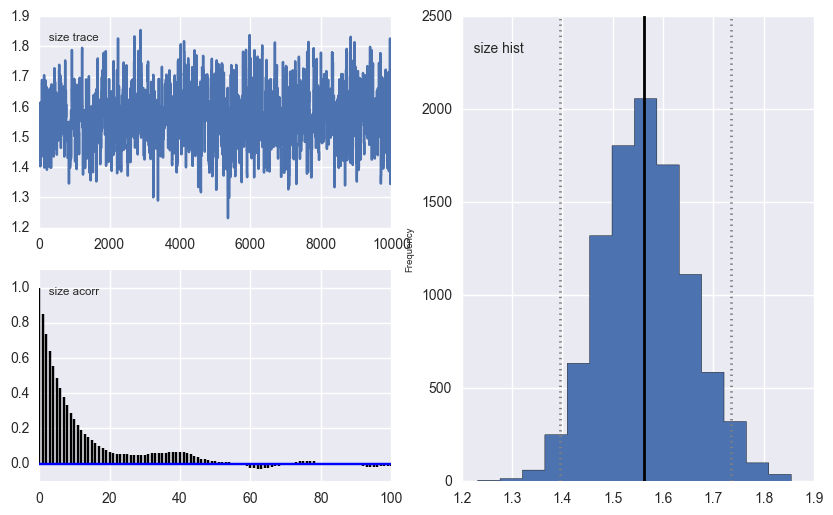

In [5]:
pm.Matplot.plot(MDL)

Here is a way to include error in `x`:

In [9]:
# add noise to observed x values
x_obs = pm.rnormal(mu=x, tau=(1e4)**-2)

# define the model/function to be fitted.
def model(x_obs, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)
    
    x_pred = pm.Normal('x', mu=x_obs, tau=(1e4)**-2) # this allows error in x_obs

    @pm.deterministic(plot=False)
    def gauss(x=x_pred, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pm.MCMC(model(x_obs, f))
MDL.use_step_method(pm.AdaptiveMetropolis, MDL.x_pred) # use AdaptiveMetropolis to "learn" how to step
MDL.sample(200000, 100000, 10)  # run chain longer since there are more dimensions

TypeError: sample() got an unexpected keyword argument 'njobs'

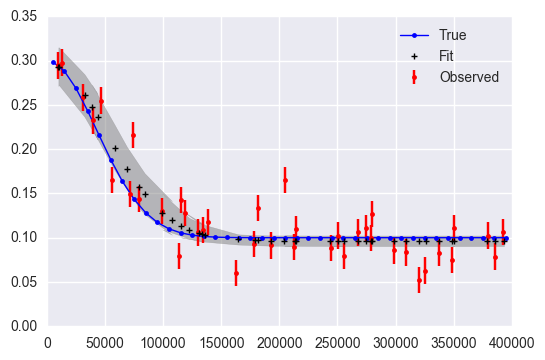

In [7]:
# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
x_fit = MDL.x_pred.trace().mean(0)
plt.plot(x,f_true,'b', marker='.', ls='-', lw=1, label='True')
plt.errorbar(x_obs, f, yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x_fit, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

Plotting amp
Plotting size
Plotting ps


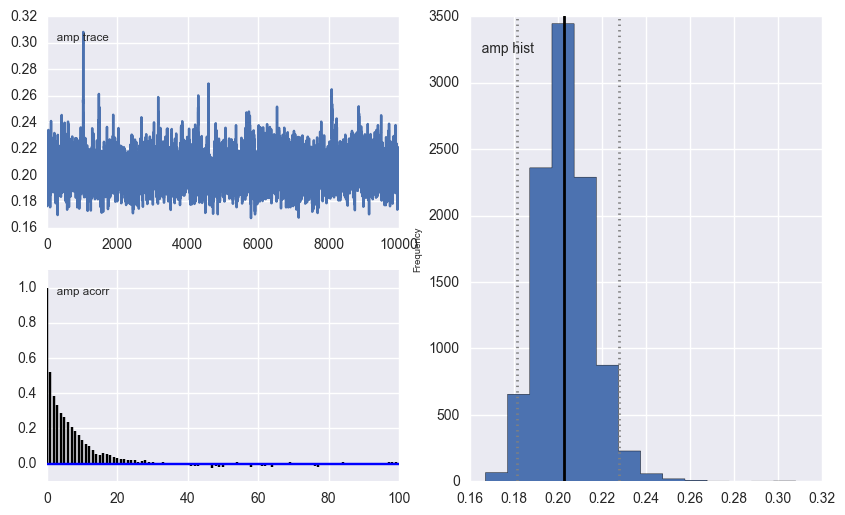

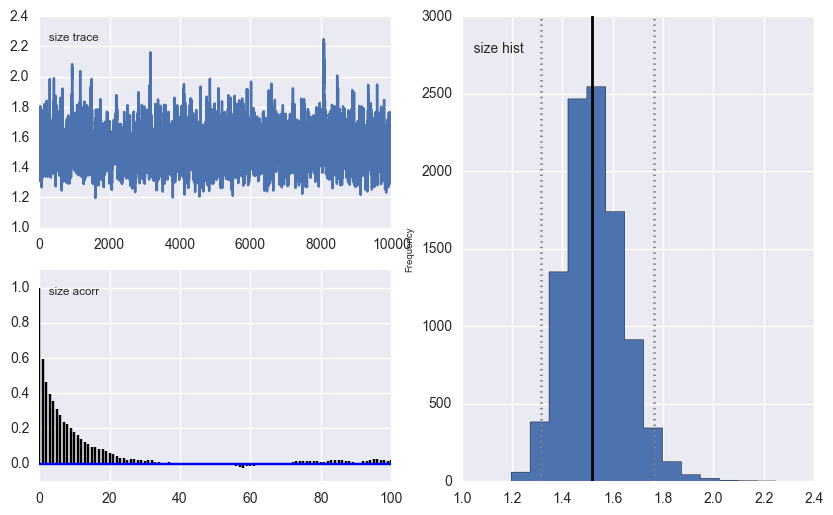

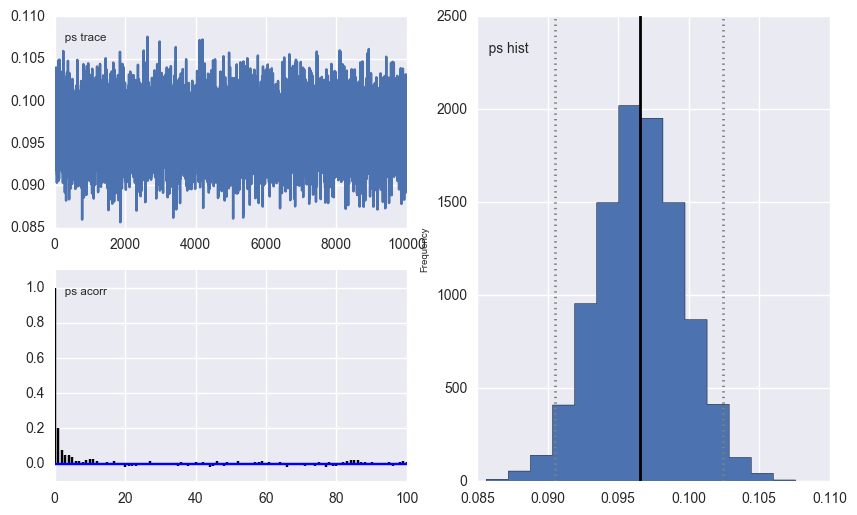

In [8]:
pm.Matplot.plot(MDL)